# Modeling A Curveball Pitch

Name: Michael Blanchard and Reilly Kobbe 

Class: PHY-2200

Professor: Dr. Titus

 Description: For our second project, our goal was to model the trajectory a curveball pitch. This includes viewing where the ball crosses the plate, a side view, and a top down view. After completing a single mode, we plotted mulitple pitches; specially we looked at where in the strike zone the curveball crossed. Additionally, we used different spinerates and velocities to get acurate data. We collected our data from the top 10 pitcher's average curveball leaderboard from Baseball Savant (https://baseballsavant.mlb.com/leaderboard/statcast?type=pitcher).

 We based our project around the Magnus Effect and drag. The Magnus Effect is sidewise force of a spinning spherical object within a gas or liquid. Drag is the opposing force acting on the ball. The combination of these two effects allows for a curveball. We wanted to investigate how these subjects effect the spin on a curveball. 

#  ODE 
 
We used the Runge-Ketta 4 or RK4 method. This method is used to find ordinary differential eqiuations (ODES). This method uses repeated small steps to calculate the solution to non linear equations. 



In [1]:
import ode 
import numpy as np #used for arrays and numerical functions
import pandas as pd #used for reading a data file
import matplotlib.pyplot as plt #used for graphing
from scipy.optimize import curve_fit #used to find the fit parameters

In [2]:
#parameters
g = 9.8 #N/kg
rho = 1.2 #kg/m^3
mu = 1.8e-5 #kg/m/s
r = 74e-3/2 #74 mm diameter, 9.25" in circumference
A = np.pi*r**2 #cross-sectional area
Cd = 0.5 #actually depends on speed
m = 0.145 #kg
b2 = 1/2*Cd*rho*A #will change as Cd changes

S = 0.01 #will change as omega and v change (spin parameter)
CL = 0 #will change with S
alpha = 1/2*CL*rho*A*r/S

In [3]:
def RK4(diffeq, y0, t, h):
    """ RK4 method for ODEs:
        Given y0 at t, returns y1 at t+h """
    k1 = h*diffeq(y0, t)                    # dy/dt at t
    k2 = h*diffeq(y0+0.5*k1, t + h/2.)      # dy/dt at t+h/2
    k3 = h*diffeq(y0+0.5*k2, t + h/2.)      # dy/dt at t+h/2
    k4 = h*diffeq(y0+k3, t + h)             # dy/dt at t+h
    return y0 + (k1+k4)/6.0 + (k2+k3)/3.0

# Data For a Singular Pitch
We began our project by modeling a single pitch. To do this, we gathered pitch data from Baseball Savant (as listed above). All we needed from the site was the speed of the curveball pitch and the spinrate of the ball. By having this information we were able to gain a greater understanding of the physics behind a curve in a curveball. Additionally, we needed to account for how far the pitching mound is from home plate (initial x value) and how high the elevation is from the pitching mound to homeplate (initial y value).
 
An important part of this project was the coordinate system. We designed our system so y would coorespond to height, x would would coorespond to how far away the pitch was being thrown (i.e the distance from the pitchers mound to home plate), and z would coorespond to where the pitch was thrown over the plate from left to right.


In [4]:
# data for signle curve ball pitch
Vmph = 80.2 #mph
spinrate = 3046 #rpm

# convert units and create initial conditions
Vmag = Vmph*0.44704 #convert mph to m/s

# initial position and velocity components
x = 18.44 #meters from home plate
y = 1.22 #elevation from homeplate
z = 0 
vx = -Vmag
vy = 0
vz = 0

t = 0 #time in s
h = 1e-2 #time step in s

# initial angular speed and velocity
omegamag = spinrate * 2*np.pi / 60 #convert to rad/s
omegax = 0
omegay = -omegamag
omegaz = 0

# lists for storing data to graph
tlist = []
xlist = []
ylist = []
zlist = []
data = []

# store initial values
tlist.append(t)
xlist.append(x)
ylist.append(y)
zlist.append(z)

# array for instantaneous position and velocity data
data = np.array([x, y, z, vx, vy, vz])
 

# Drag Function

The quadratic drag equation which is modeled in the quaddrag function allows us to see the forced that was experienced by the ball moving through space. Fortunatley, we did not have to make any changes here.

In [5]:
def quaddrag(d, t):
    x = d[0]
    y = d[1]
    z = d[2]
    vx = d[3]
    vy = d[4]
    vz = d[5]
    
    dxdt = vx
    dydt = vy
    dzdt = vz
    
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    
    Fdragx = -1/2*Cd*rho*A*v**2 * vx/v
    Fdragy = -1/2*Cd*rho*A*v**2 * vy/v
    Fdragz = -1/2*Cd*rho*A*v**2 * vz/v
    
    S = (r*omegamag)/v
    CL = .62*(S**.7)
    
    Fmagnusx = 0.5 * CL * ((rho*A*r) / S ) * (omegay*vz - omegaz*vy)
    Fmagnusy = 0.5 * CL * ((rho*A*r) / S ) * (omegay*vx - omegaz*vz)
    Fmagnusz = 0.5 * CL * ((rho*A*r) / S ) * (omegay*vy - omegaz*vx)
    
    Fgravy = -m*g
    Fnetx = Fdragx + Fmagnusx
    Fnety = Fgravy + Fdragy + Fmagnusy
    Fnetz = Fdragx + Fmagnusx
    
    dvxdt = Fnetx/m
    dvydt = Fnety/m
    dvzdt = Fnetz/m
    
    derivs = np.array([dxdt, dydt, dzdt, dvxdt, dvydt, dvzdt])
    
    return derivs

# Single Right Handed Pitch Trajectory

Our code to model the single pitch trajectory was the same as the trajectroy of hitting a baseball. However, we were able to assure the code was correct because of the curve in the graph. The x variable is 18 meters (the correct length from the mound to home plate) and the curve (z variable) was about 1.5 meters, which is very reasonable. By curve, we mean how far the ball traveled from left to right, or vice versa.
 
It may seem strange that the x variable is not on the x axis. This is because we wanted to model the pitch from a top down view, as it shows its horizontal curve. However, we also show a side view which demonstrates the decrease in elevation throughout the pitch. This happens because the pitcher is at a slight incline when on the mound. Therefor, the pitch has a decline when traveling towards homeplate.

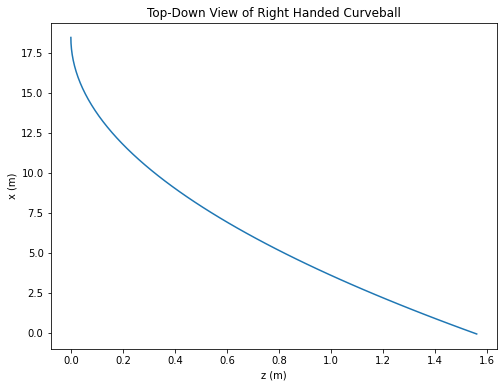

In [6]:
# The Pitch Trajectory
while x >= 0:
    
    data = RK4(quaddrag, data, t, h)
    t = t + h
    
    x = data[0]
    y = data[1]
    z = data[2]
    
    tlist.append(t)
    xlist.append(x)
    ylist.append(y)
    zlist.append(z)
    
# Plot the trajectory
plt.figure(figsize = (8,6))
plt.title("Top-Down View of Right Handed Curveball")
plt.xlabel("z (m)")
plt.ylabel("x (m)")
plt.plot(zlist, xlist)
plt.show()

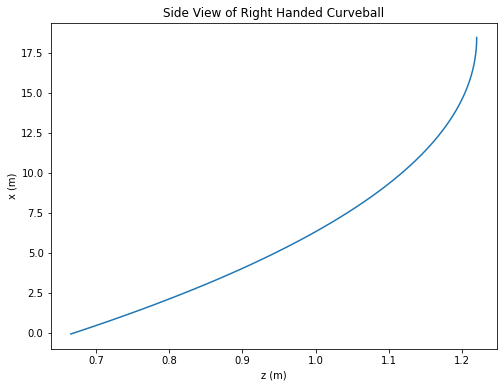

In [7]:
 # Plot the side trajectory
plt.figure(figsize = (8,6))
plt.title("Side View of Right Handed Curveball")
plt.xlabel("z (m)")
plt.ylabel("x (m)")
plt.plot(ylist, xlist)
plt.show()

# The Ending Position of a Single Pitch

After plotting the trajectory of a pitch, we wanted to see what the end corrdiantes of the pitch were. To do this we used the [-1] value in our list. This represents the last value in the list, equating to the final position of the ball. We eventually repeated this process for multiple pitches to compare results.

Y Position:  0.66561
Z Position:  1.55949


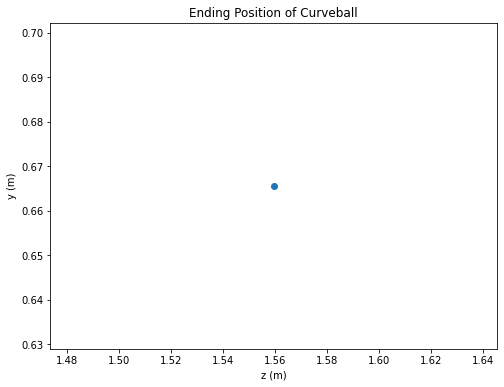

In [8]:
# Ending Position Via Scatterplot 
while x >= 0:
    
    data = ode.RK4(quaddrag, data, t, h)
    t = t + h
    
    x = data[0]
    y = data[1]
    z = data[2]
    
    tlist.append(t)
    xlist.append(x)
    ylist.append(y)
    zlist.append(z)
    
print("Y Position: ", round(ylist[-1],5))
print("Z Position: ", round(zlist[-1],5))

# Plot the trajectory
plt.figure(figsize = (8,6))
plt.title("Ending Position of Curveball")
plt.xlabel("z (m)")
plt.ylabel("y (m)")
plt.scatter(zlist[-1], ylist[-1])
plt.show()

# Multiple Pitches

After we successfully modeled a single pitch, we modeled multiple pitches. To do this we needed more data so we decided to use 10 pitches total. After learning about how to implement data files in class, we imported our data from a separate file. As stated earlier, our data came from Baseball Savant. To go through each pitch, we used a master for loop. Therefor, the code is very similar just reapeated 10 times over.

Additionally, we implemented a nested while loop which was originally used to plot the data points in the code for a singular pitch. We needed to move this into the for loop so all position data points from each pitch could be calculated and put into an array. From here, we took the last X and Z data points from each pitch and stored them in separated arrays. This piece of code was the hardest when solving for multiple pitches.

We inputed the curveball speed and spinrate into a chart and named the file curveball.txt
 
     Vmph    spinrate
     79.2    3261
     82.1    3224
     86.6    3176
     82.9    3169
     84.1    3149
     78.4    3144
     80.2    3123
     81.5    3054
     80.6    3053
     80.2    3046

In [9]:
# data for multiple curve balls
df = pd.read_csv('curveball.txt', sep='\t')
mphData = df['Vmph']
spinData = df['spinrate']

# lists for storing data to graph
yendlist = []
zendlist = []

for i in range (0,10): #For Loop to loop through each pitch
    xlist = []
    ylist = []
    zlist = []
    tlist = []
    data = []
    
    Vmph = mphData[i]
    spinrate = spinData[i] 
    
    # convert units and create initial conditions
    Vmag = Vmph*0.44704 #convert mph to m/s

    # initial position and velocity components
    x = 17.44 #meters from home plate
    y = 1 #meters high in comparison to home plate
    z = 0
    vx = -Vmag
    vy = 0
    vz = 0

    t = 0 #time in s
    h = 1e-2 #time step in s

    # initial angular speed and velocity
    omegamag = spinrate * 2*np.pi / 60 #convert to rad/s

    omegax = 0
    omegay = -omegamag
    omegaz = 0
    
        # store initial values
    tlist.append(t)
    xlist.append(x)
    ylist.append(y)
    zlist.append(z)

    # array for instantaneous position and velocity data
    data = np.array([x, y, z, vx, vy, vz])
    
    # Ending Position Via Scatterplot 
    while x >= 0: #while loop to calculate the positions of the ball
    
        data = RK4(quaddrag, data, t, h)
        t = t + h
        
        x = data[0]
        y = data[1]
        z = data[2]
        
        tlist.append(t)
        xlist.append(x)
        ylist.append(y)
        zlist.append(z)
        
    #append the last position of each pitch into a list
    yendlist.append(ylist[-1])
    zendlist.append(zlist[-1])



FileNotFoundError: [Errno 2] No such file or directory: 'curveball.txt'

# Plotting The Multiple Pitches

Since the final data points were previously stored in xendlist and yendlist, all we had to do was plot. The entire graph represents the strikezone and the data points represent where the pitch would have crossed home. The data points are not scaled to match the size of a baseball. We can deem our data acurate becuase the pitches are focused towards the right side of the plate. 

NameError: name 'yendlist' is not defined

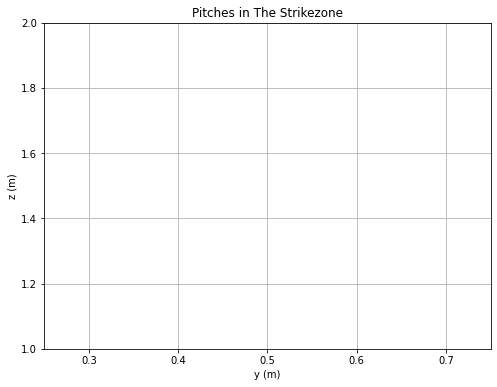

In [10]:
#Plot The Data
plt.figure(figsize = (8,6))
plt.title("Pitches in The Strikezone")
plt.xlabel("y (m)")
plt.ylabel("z (m)")
plt.grid()
plt.xlim(.25,.75)
plt.ylim(1,2)
plt.scatter(yendlist, zendlist)
#plt.plot(.5,1.35,-r)
plt.show()

# Conclusion

After creating and studying the model, we noticed that the more water particles there are, the shorter the distance the pollen travels. Although water particles stay consistent, this was a good model to see the relationship between the two varaibles. Additionally, we made the conclusion that the model definatley supports Brownian Motion, as the path of the ball was different each time. All in all, Brownian Motion is a fascinating subject. It may seem like a simple concept, but it can be very interesting when you begin to apply the idea to real life models, such as this one.